# Анализ собственного пространства свёрток

In [56]:
import torch
#from torch.autograd import Variable
#import torch.nn.functional as F
import torch.nn as nn

import pdb
from biopandas.pdb import PandasPdb
ppdb = PandasPdb()

import os
import random
import numpy as np
from scipy.sparse import linalg
#from tqdm.auto import tqdm
from tqdm import tqdm

import seaborn as sns
#%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn-paper')

In [131]:
#plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 28
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
#import collections    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = {}'.format(device))

device = cpu


Возьмем по одной случайной матрице смежности смоделированной структуры белка для каждого таргета из CASP11, CASP12

In [6]:
tqdm._instances.clear()

In [15]:
DATA = list()
unwanted = {'.DS_Store', 'adjacency', 'adjacency_old'}

for casp in ['CASP11', 'CASP12']:
    cad_path = '../cad_results/' + casp
    targets = sorted(os.listdir(cad_path))
    targets = [target for target in targets if target not in unwanted]
    
    for target in tqdm(targets):
        target = target[:-11]
        adj_path = '../../data/' + casp + '/models/' + target + '/adjacency/'
        models_path = '../../data/' + casp + '/models/' + target
    
        models = sorted(os.listdir(adj_path))
        models = [model for model in models if model not in unwanted]
        model = random.choice(models)
    
        temp = ppdb.read_pdb(models_path + '/'+ model[:-8])
        temp_model = ppdb.df['ATOM']
        coords = temp_model[['x_coord', 'y_coord', 'z_coord']].values
        protein_size = temp_model.shape[0]
        adjacency = np.zeros((protein_size, protein_size))
        with open(adj_path + model) as fp:
            line = fp.readline()
            while line:
                for t in line.strip().split(' '):
                    adjacency[int(t.split('_')[0])][int(t.split('_')[1])] = 1
                    adjacency[int(t.split('_')[1])][int(t.split('_')[0])] = 1
                line = fp.readline()

        DATA.append((target, model[:-8], adjacency, coords)) # model = <name>_adj.txt

100%|██████████| 37/37 [00:10<00:00,  3.45it/s]


### Свёртка

In [5]:
class GraphConv(nn.Module):
    '''
    Graph Convolution Layer according to (T. Kipf and M. Welling, ICLR 2017)
    Additional tricks (power of adjacency matrix and weight self connections) as in the Graph U-Net paper
    '''
    def __init__(self,
                in_features,
                out_features,
                activation=None,
                adj_sq=False,
                scale_identity=False):
        super(GraphConv, self).__init__()
        self.fc = nn.Linear(in_features=in_features, out_features=out_features).double()
        self.adj_sq = adj_sq
        self.activation = activation
        self.scale_identity = scale_identity
            
    def laplacian_batch(self, A):
        batch=1
        N = A.shape[0]
        #batch, N = A.shape[:2]
        if self.adj_sq:
            A = torch.bmm(A, A)  # use A^2 to increase graph connectivity
        I = torch.eye(N).unsqueeze(0).double().to(device)
        if self.scale_identity:
            I = 2 * I  # increase weight of self connections
        A_hat = A + I
        D_hat = (torch.sum(A_hat, 1) + 1e-5) ** (-0.5)
        #print('-'*40)
        #print(batch)
        #print(A_hat.shape)
        #print(D_hat.shape)
        #print(D_hat.view(batch, N, 1).shape)
        #print('-'*40)
        L = D_hat.view(batch, N, 1) * A_hat * D_hat.view(batch, 1, N)
        #print('L shape:{}'.format(L.shape))
        return L

    def forward(self, data):
        x, A = data
        #print('conv layer')
        x = x.view(1,x.shape[0], x.shape[1])
        a = torch.bmm(self.laplacian_batch(A), x)
        #print('DADX shape:{}'.format(a.shape))
        x = self.fc(a.double())
        
        #print('x after FC shape:{}'.format(x.shape))
        if self.activation is not None:
            x = self.activation(x)
        #print('x after RELU shape:{}'.format(x.shape))
        return (x, A)

In [ ]:
self.gconv = nn.Sequential(*([GraphConv(in_features=in_features if layer == 0 else filters[layer - 1], 
                                                out_features=f, 
                                                activation=nn.ReLU(inplace=True),
                                                adj_sq=adj_sq,
                                                scale_identity=scale_identity) for layer, f in enumerate(filters)]))

#x = self.gconv(data)[0]

## Собственные числа матриц A и X до сверток для CASP12

In [40]:
tqdm._instances.clear()

In [25]:
# на данной матрице выдало LinAlgError: SVD did not converge 
DATA.pop(88)

In [33]:
DATA.pop(98)

('T0891', 'MULTICOM-CONSTRUCT_TS5', array([[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 1.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]]), array([[36.805, 42.731, 33.964],
        [38.053, 43.012, 34.709],
        [38.159, 44.479, 34.972],
        ...,
        [34.924, 53.373, 18.628],
        [34.599, 54.819, 18.973],
        [34.856, 53.151, 17.125]]))

In [38]:
#all_eigens_A = []
for target, model, A, _ in tqdm(DATA[98:]):
    eigensA = np.linalg.svd(A)[1]
    all_eigens_A.append(eigensA)
    
    fig=plt.figure()
    plt.ion()
    plt.rc('axes', labelsize=15)
    plt.bar(np.arange(len(eigensA)), eigensA, color='green')
    #plt.plot([0,1000], [4, 4], ls='--', color='green')
    plt.title(target + ': ' + model)
    plt.xlabel('Номер собственного числа A')
    plt.ylabel('Абсолютное значение числа')
    plt.savefig('../temp/' + target + '_A_before_conv.png')
    plt.close(fig)
    #plt.show()

100%|██████████| 21/21 [11:07<00:00, 31.77s/it]


In [39]:
len(all_eigens_A)

119

In [41]:
all_eigens_X = []
for target, model, A, X in tqdm(DATA):
    eigensX = np.linalg.svd(X)[1]
    all_eigens_X.append(eigensX)
    
    fig=plt.figure()
    plt.ion()
    plt.rc('axes', labelsize=15)
    plt.bar(np.arange(len(eigensX)), eigensX)
    plt.title(target + ': ' + model)
    plt.xlabel('Номер собственного числа X')
    plt.ylabel('Абсолютное значение числа')
    plt.savefig('../temp/' + target + '_X_before_conv.png')
    plt.close(fig)

100%|██████████| 119/119 [00:58<00:00,  2.03it/s]


## Собственные числа матрицы после свертки для CASP12

In [42]:
conv = GraphConv(in_features=3, 
                 out_features=64, 
                 activation=nn.ReLU(inplace=True),
                 adj_sq=False,
                 scale_identity=False)

In [43]:
all_eigens_after_1conv = []

for target, model, A, X in tqdm(DATA):
    X_after_conv, _ = conv((torch.tensor(X),torch.tensor(A)))
    eigens_after = np.linalg.svd(X_after_conv.detach().numpy())[1][0]
    all_eigens_after_1conv.append(eigens_after)
    
    fig=plt.figure()
    plt.ion()
    plt.rc('axes', labelsize=15)
    plt.bar(np.arange(len(eigens_after)), eigens_after)
    plt.title(target + ': ' + model)
    plt.xlabel('Номер собственного числа матрицы после свёртки')
    plt.ylabel('Абсолютное значение числа')
    plt.savefig('../temp/' + target + '_X_after_conv.png')
    plt.close(fig)

100%|██████████| 119/119 [02:41<00:00,  1.36s/it]


## Анализ

In [189]:
import pickle
DATA_eigens = [all_eigens_A, all_eigens_X, all_eigens_after_1conv]
with open('eigens.pickle', 'wb') as handle:
    pickle.dump(DATA_eigens, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [190]:
#with open('eigens.pickle', 'rb') as handle:
#    DATA_eigens = pickle.load(handle)

In [143]:
plt.rcParams['lines.markersize'] = 7
plt.rcParams['figure.figsize'] = (20.0, 12.0)

In [167]:
from scipy.spatial import ConvexHull
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

colors from https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib

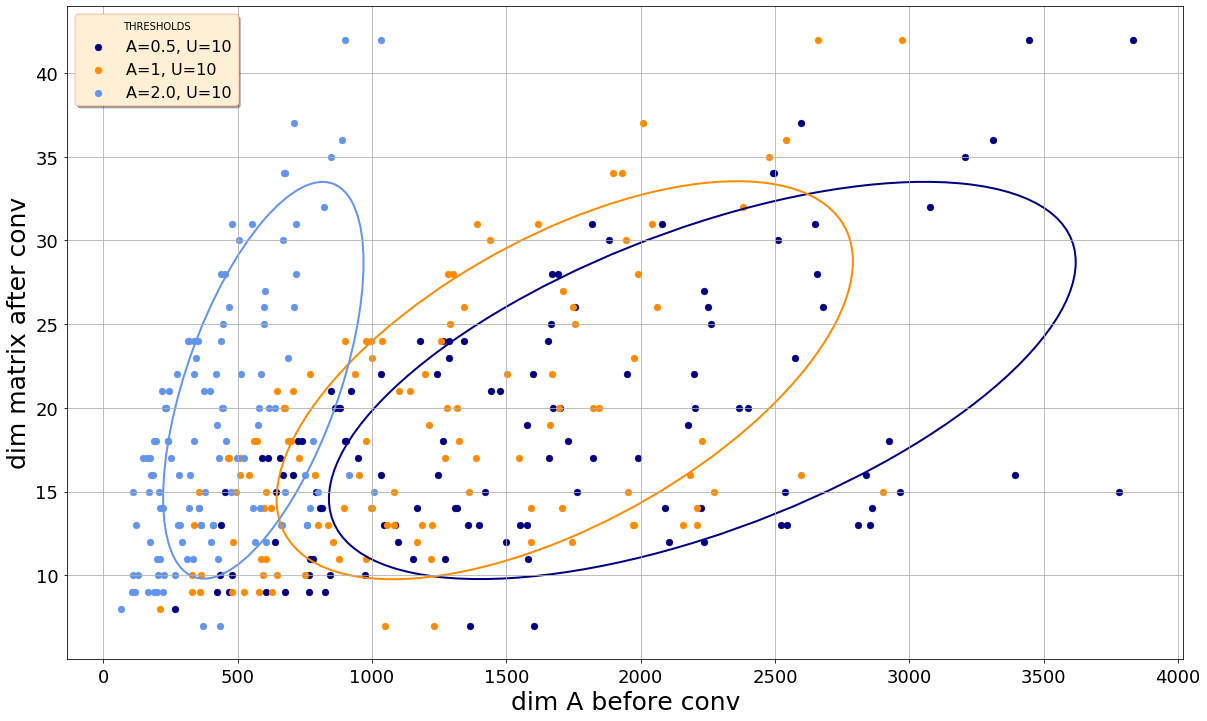

In [261]:
#thresholds = [0.2, 0.5, 1, 1.5, 2.0]
thresholdsA = [0.5, 1, 2.0]
thresholds = [10]

colors = ['navy', 'darkorange', 'cornflowerblue', 'forestgreen', 
          'red', 'sienna', 'darkgoldenrod', 'darkorchid', 'deeppink']

count = 0
for k, thresholdA in enumerate(thresholdsA):
    for threshold in thresholds:
        dims_A = []
        dims_X_after = []
        for i in range(len(all_eigens_A)):
            dims_A.append(len(all_eigens_A[i][all_eigens_A[i] > thresholdA]))
            dims_X_after.append(len(all_eigens_after_1conv[i][all_eigens_after_1conv[i] > threshold]))
        
        points = np.stack((np.array(dims_A), np.array(dims_X_after)), axis=-1)
        
        dims_A = np.array(dims_A)[:,np.newaxis]
        dims_X_after = np.array(dims_X_after)[:,np.newaxis]
    
        
        
        axes = plt.gca()
        #axes.set_size_inches(20,12)
        #axes.set_xlim([0,5000])
        #axes.set_ylim([0,80])
        plt.grid(True)
        
        ############### ellipse
        a_points = np.array(points)
        x = a_points[:, 0]
        y = a_points[:, 1]
        ell = EllipseModel()
        ell.estimate(a_points)
        xc, yc, a, b, theta = ell.params
        #print("center = ",  (xc, yc))
        #print("angle of rotation = ",  theta)
        #print("axes = ", (a,b))
        #plt.scatter(xc, yc, color='red', s=100)
        ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, 
                            edgecolor=colors[count], facecolor='none', linewidth=2)
        axes.add_patch(ell_patch)
        ###############
        
        ############### CONVEX HULL FROM POINT CLOUD
        #hull = ConvexHull(points)
        #for simplex in hull.simplices:
        #    plt.plot(points[simplex, 0], points[simplex, 1], 'k-', color=colors[count])
        ############### 
        
        ############ Another ellipse
        #### Formulate and solve the least squares problem ||Ax - b ||^2
        '''
        A = np.hstack([dims_A**2, dims_A * dims_X_after, dims_X_after**2, dims_A, dims_X_after])
        b = np.ones_like(dims_X_after)
        x = np.linalg.lstsq(A, b)[0].squeeze()
        x_coord = np.linspace(0,5500,300)
        y_coord = np.linspace(0,66,300)
        X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
        Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
        #plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=colors[count], linewidths=2)
        '''
        ############
        
        plt.scatter(dims_A, dims_X_after, 
                    label='A={}, U={}'.format(thresholdA,threshold), 
                    color=colors[count])
        #plt.title()
        plt.xlabel('dim A before conv')
        plt.ylabel('dim matrix after conv')
        legend = plt.legend(loc='best', shadow=True, title='THRESHOLDS')
        frame = legend.get_frame()
        frame.set_facecolor('papayawhip')
        frame.set_edgecolor('red')
        
        plt.savefig('../temp/eigens_A=1_2.png')
        #plt.show()
        
        count += 1
        